# Introducción
Este notebook implementa y ejecuta los siguientes algoritmos de segmentación de imágenes.
- Watershed
- Gradient Vector Flow (GVF)
- Agregación Multiescala (k-means multi-escala)
- Graph-cuts (GrabCut)

Integrantes:
Tinoco Guerrero Gerardo,
Tejada Nava Julio Alejandro,
Pino Rosas Octavio

# Librerias e Imagenes

In [ ]:
import cv2; import numpy as np; import matplotlib.pyplot as plt; from pathlib import Path
img_path     = 'Imagenes/Ejemplo_3.png'
img_l_path   = 'Imagenes/Ejemplo_3_L.png'

## Carga y preprocesamiento

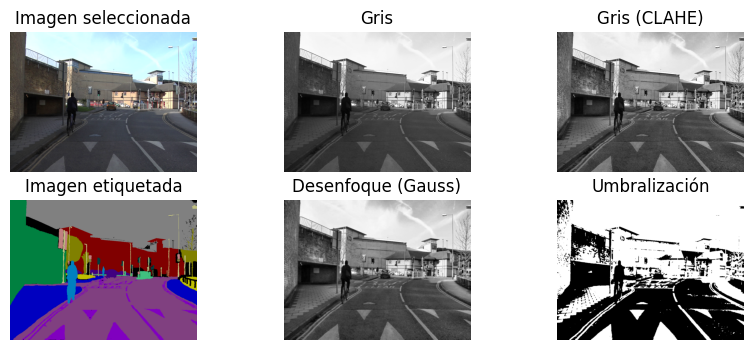

In [ ]:
# Carga y preprocesado
img           = cv2.imread(str(img_path))                                                                       # Carga la imagen desde disco
img_label     = cv2.imread(str(img_l_path))                                                                     # Carga la imagen de etiquetas
gris          = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                                                           # Convierte a escala de grises
clahe         = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))                                              # Ecualización adaptativa por bloques
gris_eq       = clahe.apply(gris)                                                                               # Gris ecualizado para mejorar contraste en zonas inferiores
desenfoque    = cv2.GaussianBlur(gris_eq, (5, 5), 0)                                                            # Suavizado gaussiano sobre gris ecualizado
img_bilateral = cv2.bilateralFilter(img, d=7, sigmaColor=25, sigmaSpace=7)                                      # Suaviza preservando bordes
_, th_otsu    = cv2.threshold(desenfoque, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)                          # Umbralización automática de Otsu
_, th_tri     = cv2.threshold(desenfoque, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)                      # Umbralización automática por Triángulo
umbral        = cv2.bitwise_or(th_otsu, th_tri)                                                                 # Combina ambos umbrales en una máscara
# Vista de preprocesado.
plt.figure(figsize=(10, 4))
plt.subplot(2, 3, 1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));         plt.title(f'Imagen seleccionada');  plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(gris, cmap='gray');                            plt.title('Gris');                  plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(gris_eq, cmap='gray');                         plt.title('Gris (CLAHE)');          plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB));   plt.title('Imagen etiquetada');     plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(desenfoque, cmap='gray');                      plt.title('Desenfoque (Gauss)');    plt.axis('off')
plt.subplot(2, 3, 6); plt.imshow(umbral, cmap='gray');                          plt.title('Umbralización');         plt.axis('off')
plt.show()

## Watershed

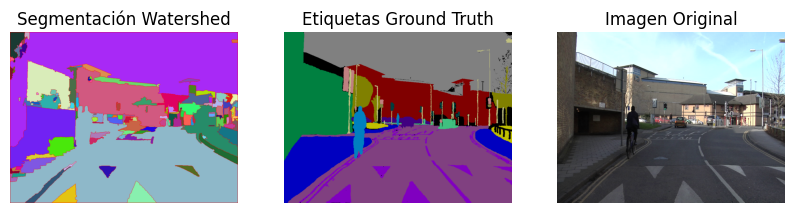

In [ ]:
# Morfología: apertura + cierre suaves
kernel  = np.ones((3,3), np.uint8)                                                                              # Kernel morfológico 3x3 de tipo uint8
opening = cv2.morphologyEx(umbral, cv2.MORPH_OPEN, kernel, iterations=1)                                        # Apertura para eliminar ruido pequeño
opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)                                      # Cierre para rellenar huecos pequeños
morph_grad = cv2.morphologyEx(umbral, cv2.MORPH_GRADIENT, kernel)                                               # Gradiente morfológico sobre la máscara
# Fondo seguro y primer plano por DT (más inclusivo)
sure_bg    = cv2.dilate(opening, kernel, iterations=2)                                                          # Dilata para obtener fondo seguro (sure background)
dist       = cv2.distanceTransform(opening, cv2.DIST_L2, 3)                                                     # Transformada de distancia euclidiana
# Umbral adaptativo del DT por percentil para robustez en regiones débiles
dt_vals    = dist[opening > 0]
th_dt      = float(np.percentile(dt_vals, 40)) if dt_vals.size > 0 else 0.3*float(dist.max())                   # Percentil 40 como compromiso
sure_fg    = (dist >= th_dt).astype(np.uint8)*255                                                               # Primer plano seguro binario
# Refuerzo con máximos regionales
dt_dil       = cv2.dilate(dist, np.ones((3,3), np.uint8), iterations=1)                                         # Dilata DT para detectar máximos locales
regional_max = (dist >= dt_dil).astype(np.uint8)*255                                                            # Marca máximos regionales como 255
regional_max = cv2.morphologyEx(regional_max, cv2.MORPH_OPEN, kernel, iterations=1)                             # Limpia máximos con apertura
sure_fg      = cv2.bitwise_or(sure_fg, regional_max)                                                            # Refuerza primer plano con máximos
# Gradiente de Sobel como base para umbrales de Canny
sobel_x   = cv2.Sobel(desenfoque, cv2.CV_64F, 1, 0, ksize=3)                                                    # Calcula gradiente en x con Sobel
sobel_y   = cv2.Sobel(desenfoque, cv2.CV_64F, 0, 1, ksize=3)                                                    # Calcula gradiente en y con Sobel
grad_mag  = np.sqrt(sobel_x**2 + sobel_y**2)                                                                    # Magnitud del gradiente
grad_mag  = (grad_mag/(grad_mag.max() + 1e-8)*255).astype(np.uint8)                                             # Normaliza a [0,255]
# Umbrales de Canny por percentiles del gradiente
low_th              = int(np.percentile(grad_mag, 30))                                                          # Umbral bajo: 30% del gradiente
high_th             = int(np.percentile(grad_mag, 70))                                                          # Umbral alto: 70% del gradiente
high_th             = max(high_th, low_th + 1)                                                                  # Garantiza high > low
bordes              = cv2.Canny(desenfoque, low_th, high_th)                                                    # Bordes con Canny adaptativo
unknown             = cv2.subtract(sure_bg, sure_fg)                                                            # Región desconocida = fondo seguro - primer plano
ref_mask            = cv2.bitwise_or(((morph_grad>0).astype(np.uint8)*255), bordes)                             # Refuerzo por gradiente morfológico + bordes
unknown[ref_mask>0] = 255                                                                                       # Refuerza unknown en píxeles de borde y gradiente
# Marcadores y watershed
_, markers              = cv2.connectedComponents(sure_fg)                                                      # Etiqueta componentes conectados del primer plano
markers                 = markers + 1                                                                           # Incrementa etiquetas para reservar 0
markers[unknown == 255] = 0                                                                                     # Asigna 0 a regiones desconocidas
# Mapa de elevación: magnitud del gradiente (Sobel) en BGR para watershed
elev_bgr   = cv2.cvtColor(grad_mag, cv2.COLOR_GRAY2BGR)                                                         # Convierte gradiente a BGR para watershed
markers_ws = cv2.watershed(elev_bgr, markers)                                                                   # Aplica watershed con mapa de elevación
# Colorear etiquetas
h, w            = gris.shape                                                                                    # Altura y ancho de la imagen
labels          = markers_ws                                                                                    # Aliasing de etiquetas
resultado_color = np.zeros((h, w, 3), dtype=np.uint8)                                                           # Imagen de resultado en color
uniq            = np.unique(labels)                                                                             # Etiquetas únicas del resultado watershed
uniq            = uniq[uniq >= 2]                                                                               # Filtra etiquetas válidas (>=2)
colors          = np.random.RandomState(7).randint(0,255,(len(uniq)+2,3),dtype=np.uint8)                        # Paleta aleatoria para etiquetas
# Borde watershed en rojo
resultado_color[labels == -1] = (0, 0, 255)                                                                     # Marca bordes watershed en rojo
# Colorear etiquetas válidas de forma vectorizada
mask_valid                    = labels >= 2                                                                     # Máscara para etiquetas válidas
resultado_color[mask_valid]   = colors[(labels[mask_valid] % colors.shape[0])]                                  # Asigna colores basados en módulo de etiquetas
# Visualización
plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(resultado_color, cv2.COLOR_BGR2RGB)); plt.title('Segmentación Watershed'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB));       plt.title('Etiquetas Ground Truth'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));             plt.title('Imagen Original');        plt.axis('off')
plt.show()

## Gradient Vector Flow (GVF)

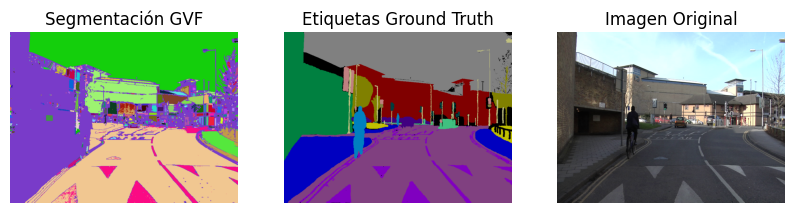

In [ ]:
# Configuración numérica
np.seterr(all='ignore')                                                                                         # Suprime advertencias numéricas de NumPy
gris_f   = gris.astype(np.float32)                                                                              # Convierte gris a float para cálculos
# Bordes multi‑escala
bordes1  = cv2.Canny(gris, 60, 120)                                                                             # Bordes Canny en imagen gris (umbral bajo/alto)
bordes2  = cv2.Canny(cv2.GaussianBlur(gris, (5, 5), 0), 40, 80)                                                 # Bordes Canny tras Gauss (más sensible)
bordes   = cv2.bitwise_or(bordes1, bordes2)                                                                     # Combina bordes de ambos escalas
bordes_f = bordes.astype(np.float32)/255.0                                                                      # Normaliza mapa de bordes a [0,1]
# Gradiente del mapa de bordes
fx   = cv2.Sobel(bordes_f, cv2.CV_32F, 1, 0, ksize=3)                                                           # Derivada en x del mapa de bordes
fy   = cv2.Sobel(bordes_f, cv2.CV_32F, 0, 1, ksize=3)                                                           # Derivada en y del mapa de bordes
mag2 = fx**2 + fy**2                                                                                            # Magnitud al cuadrado
# Inicialización e iteración del GVF
u, v      = fx.copy(), fy.copy()                                                                                # Inicializa campo GVF con gradiente original
mu, iters = 0.1, 120                                                                                            # Parámetros GVF: suavizado (mu) y número de iteraciones
for _ in range(iters):                                                                                          # Itera el proceso GVF
    # Aproximación del laplaciano mediante derivadas segundas con Sobel.
    uxx          = cv2.Sobel(u, cv2.CV_32F, 2, 0, ksize=3); uyy = cv2.Sobel(u, cv2.CV_32F, 0, 2, ksize=3)       # Segundas derivadas para laplaciano de u
    vxx          = cv2.Sobel(v, cv2.CV_32F, 2, 0, ksize=3); vyy = cv2.Sobel(v, cv2.CV_32F, 0, 2, ksize=3)       # Segundas derivadas para laplaciano de v
    lap_u, lap_v = uxx + uyy, vxx + vyy                                                                         # Laplacianos de u y v
    u            = u + mu*lap_u - (u - fx)*mag2                                                                 # Actualiza u: difunde y atrae hacia fx (peso mag^2)
    v            = v + mu*lap_v - (v - fy)*mag2                                                                 # Actualiza v: difunde y atrae hacia fy (peso mag^2)
# Postprocesado y construcción de regiones
gvf_mag       = np.sqrt(u*u + v*v)                                                                              # Magnitud del campo GVF
gvf_norm      = cv2.normalize(gvf_mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)                          # Normaliza magnitud a rango 0–255
_, gvf_thresh = cv2.threshold(gvf_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)                            # Umbraliza automáticamente sobre magnitud GVF
# Operaciones morfológicas para limpiar ruido y cerrar huecos.
kernel     = np.ones((3, 3), np.uint8)                                                                          # Kernel 3x3 para morfología
gvf_thresh = cv2.morphologyEx(gvf_thresh, cv2.MORPH_OPEN, kernel, iterations=1)                                 # Apertura para quitar ruido pequeño
gvf_thresh = cv2.morphologyEx(gvf_thresh, cv2.MORPH_CLOSE, kernel, iterations=2)                                # Clausura para rellenar huecos
# Combinación con bordes detectados para reforzar contornos.
combinado = cv2.bitwise_or(gvf_thresh, bordes)                                                                  # Refuerza contornos uniendo GVF y bordes
combinado = cv2.morphologyEx(combinado, cv2.MORPH_CLOSE, kernel, iterations=1)                                  # Cierra pequeños huecos restantes
# Construcción de regiones.
regiones_bin = (cv2.bitwise_not(combinado) > 0).astype(np.uint8)                                                # Regiones candidatas como complemento de contornos
h, w         = gris.shape                                                                                       # Alto y ancho de la imagen
mascara_ff   = np.zeros((h + 2, w + 2), dtype=np.uint8)                                                         # Máscara requerida por floodFill (con borde extra)
regiones_ff  = regiones_bin.copy(); cv2.floodFill(regiones_ff, mascara_ff, (0, 0), 0)                           # Rellena desde (0,0) para eliminar fondo conectado
# Etiquetado de componentes conectados.
num, etiquetas      = cv2.connectedComponents(regiones_ff)                                                      # Etiqueta componentes conectados
etiquetas_refinadas = etiquetas.copy()                                                                          # Copia inicial de etiquetas para refinamiento
siguiente_etiqueta  = int(num)                                                                                  # Contador para nuevas etiquetas tras k‑means
min_area            = 800                                                                                       # Sólo se refinan regiones suficientemente grandes
# Criterio de parada para k‑means.
crit = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.5)                                            # Criterio de parada de k‑means
for l in range(1, num):                                                                                         # Itera sobre cada etiqueta
    mask_l = (etiquetas == l)                                                                                   # Máscara de la región actual
    area   = int(mask_l.sum())                                                                                  # Tamaño (número de píxeles) de la región
    if area > min_area:                                                                                         # Sólo procesa regiones suficientemente grandes
        vals = gris[mask_l].reshape((-1, 1)).astype(np.float32)                                                 # Intensidades en gris de la región como vector
        if vals.shape[0] >= 2:                                                                                  # Evita k‑means si <2 píxeles
            _, lab_km, centers = cv2.kmeans(
                vals, 2, None, crit, 5, cv2.KMEANS_PP_CENTERS
            )                                                                                                   # Aplica k‑means (k=2) con inicialización PP
            lab_km = lab_km.flatten()                                                                           # Aplana etiquetas de clúster
            ys, xs = np.where(mask_l)                                                                           # Coordenadas de píxeles de la región
            for j in range(len(ys)):                                                                            # Reasigna píxeles según clúster
                if lab_km[j] == 1:
                    etiquetas_refinadas[ys[j], xs[j]] = siguiente_etiqueta                                      # Asigna nueva etiqueta al clúster 1
            siguiente_etiqueta += 1                                                                             # Incrementa etiqueta para próxima separación
# Visualización del resultado
num_refined     = int(etiquetas_refinadas.max()) + 1                                                            # Número total de etiquetas después del refinamiento
colores         = np.random.RandomState(21).randint(0, 255, (num_refined, 3), dtype=np.uint8)                   # Paleta de colores aleatoria por etiqueta
resultado_color = np.zeros((h, w, 3), dtype=np.uint8)                                                           # Imagen de salida en color inicializada
for y in range(h):                                                                                              # Recorre filas de la imagen
    for x in range(w):                                                                                          # Recorre columnas de la imagen
        resultado_color[y, x] = colores[etiquetas_refinadas[y, x] % num_refined]                                # Asigna color según etiqueta (módulo por seguridad)
# Visualización
plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(resultado_color, cv2.COLOR_BGR2RGB)); plt.title('Segmentación GVF');       plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB));       plt.title('Etiquetas Ground Truth'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));             plt.title('Imagen Original');        plt.axis('off')
plt.show()

## Agregación Multiescala (k-means multi-escala)

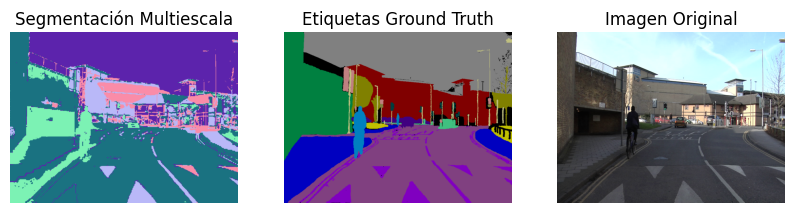

In [ ]:
# Preparación de parámetros y escalas
h, w = img.shape[:2]                                                                                            # Dimensiones de la imagen (alto, ancho)
# Parámetros y escalas
escalas  = [1.0, 0.5, 0.25]; K = 5                                                                              # Escalas de trabajo y número de clusters K
criterio = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.8)                                        # Criterio de parada para k‑means
intentos = 5                                                                                                    # Número de intentos de inicialización para k‑means
# Acumuladores de etiquetas y pesos
pila_etiquetas = []; pesos_borde = []                                                                           # Acumuladores de etiquetas y mapas de borde por escala
# Procesamiento multiescala por escala
for scale in escalas:                                                                                        # Itera sobre cada escala definida
    ws, hs          = max(1, int(w*scale)), max(1, int(h*scale))                                                # Calcula tamaño escalado (ancho, alto) con mínimos de 1
    img_s           = cv2.resize(img, (ws, hs), interpolation=cv2.INTER_AREA)                                   # Redimensiona imagen a la escala actual
    img_s_bil       = cv2.bilateralFilter(img_s, d=7, sigmaColor=25, sigmaSpace=7)                              # Aplica filtro bilateral a la imagen escalada
    img_lab         = cv2.cvtColor(img_s_bil, cv2.COLOR_BGR2LAB)                                                # Convierte a espacio de color LAB
    data            = img_lab.reshape((-1,3)).astype(np.float32)                                                # Reorganiza a vector de píxeles (N x 3) en float32
    _, lab, centers = cv2.kmeans(data, K, None, criterio, intentos, cv2.KMEANS_PP_CENTERS)                      # Aplica k‑means con K clusters e inicialización PP
    labels_s        = lab.reshape((hs, ws))                                                                     # Reconvierte etiquetas a imagen (hs x ws)
    labels_full     = cv2.resize(labels_s.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)            # Reescala etiquetas a tamaño original (nearest)
    pila_etiquetas.append(labels_full)                                                                          # Agrega etiquetas reescaladas a la pila
    gris_s          = cv2.cvtColor(img_s_bil, cv2.COLOR_BGR2GRAY)                                               # Convierte imagen escalada filtrada a gris
    bordes_s        = cv2.Canny(gris_s, 50, 100)                                                                # Detecta bordes Canny en escala actual
    bordes_full     = cv2.resize(bordes_s, (w, h), interpolation=cv2.INTER_NEAREST)                             # Reescala mapa de bordes al tamaño original
    pesos_borde.append(bordes_full)                                                                             # Agrega mapa de bordes a acumulador de pesos
# Empaquetado de etiquetas y bordes
pila_etiquetas_np = np.stack(pila_etiquetas, axis=2)                                                            # Apila etiquetas por escala en tensor (h x w x S)
pila_bordes_np    = np.stack(pesos_borde, axis=2)                                                               # Apila mapas de bordes por escala (h x w x S)
# Agregación y votación ponderada
etiquetas_finales = np.zeros((h, w), dtype=np.uint8)                                                            # Inicializa mapa final de etiquetas
for y in range(h):                                                                                              # Recorre filas de la imagen
    for x in range(w):                                                                                          # Recorre columnas de la imagen
        hist = np.zeros(K, dtype=np.float32)                                                                    # Histograma de votos por etiqueta (K)
        for i in range(pila_etiquetas_np.shape[2]):                                                             # Itera sobre cada escala apilada
            wgt = 1.0 + 0.5*(pila_bordes_np[y, x, i]/255.0)                                                     # Peso mayor si hay borde (escala i) en píxel
            hist[pila_etiquetas_np[y, x, i]] += wgt                                                             # Suma voto ponderado a etiqueta correspondiente
        etiquetas_finales[y, x] = np.argmax(hist)                                                               # Asigna etiqueta con mayor voto
# Suavizado por mayoría (3x3)
def majority_pass(labels):                                                                                      # Filtro de mayoría local 3x3 para suavizar etiquetas
    out = labels.copy()                                                                                         # Copia de trabajo
    for yy in range(1, h-1):                                                                                    # Itera filas internas (evita bordes)
        for xx in range(1, w-1):                                                                                # Itera columnas internas
            neigh       = labels[yy-1:yy+2, xx-1:xx+2].flatten()                                                # Vecindario 3x3 a vector
            counts      = np.bincount(neigh, minlength=K)                                                       # Conteo de ocurrencias por etiqueta
            out[yy, xx] = np.argmax(counts)                                                                     # Asigna la etiqueta más frecuente
    return out                                                                                                  # Devuelve etiquetas suavizadas
etiquetas_finales = majority_pass(etiquetas_finales); etiquetas_finales = majority_pass(etiquetas_finales)      # Aplica dos pasadas de mayoría para mayor consistencia
# Coloreado de etiquetas
colores         = np.random.RandomState(99).randint(0,255,(K,3),dtype=np.uint8)                                 # Paleta de colores aleatoria para K etiquetas
resultado_color = np.zeros_like(img)                                                                            # Imagen de resultado en color
for y in range(h):                                                                                              # Recorre filas
    for x in range(w):                                                                                          # Recorre columnas
        resultado_color[y, x] = colores[etiquetas_finales[y, x]]                                                # Asigna color según etiqueta final
# Visualización
plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(resultado_color, cv2.COLOR_BGR2RGB)); plt.title('Segmentación Multiescala'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB));       plt.title('Etiquetas Ground Truth');   plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));             plt.title('Imagen Original');          plt.axis('off')
plt.show()

## Graph-cuts (GrabCut)

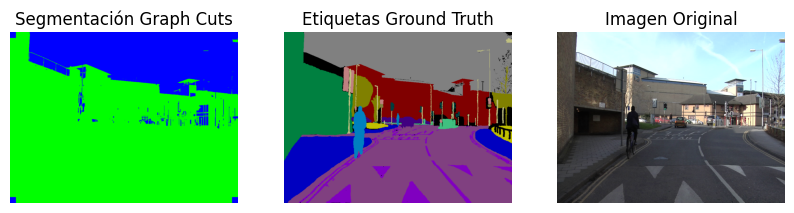

In [ ]:
# Dimensiones y modelos
h, w = img.shape[:2]                                                                                            # Obtiene alto y ancho de la imagen
mascara  = np.zeros((h, w), np.uint8)                                                                           # Máscara de trabajo para GrabCut
bgdModel = np.zeros((1, 65), np.float64)                                                                        # Modelo de fondo para GrabCut
fgdModel = np.zeros((1, 65), np.float64)                                                                        # Modelo de primer plano para GrabCut
pad = 25                                                                                                        # Margen en píxeles para definir esquinas como fondo
# Inicialización de máscara de fondo (esquinas)
mascara[:pad, :pad]  = cv2.GC_BGD; mascara[:pad, -pad:]   = cv2.GC_BGD                                          # Marca esquina superior izquierda y derecha como fondo
mascara[-pad:, :pad] = cv2.GC_BGD; mascara[-pad:, -pad:]  = cv2.GC_BGD                                          # Marca esquina inferior izquierda y derecha como fondo
# Región elíptica de primer plano (probable)
cx, cy = w//2, h//2                                                                                             # Centro de la elipse (centro de la imagen)
ax, ay = int(w*0.3), int(h*0.3)                                                                                 # Semiejes de la elipse (proporción de la imagen)
for y in range(h):                                                                                              # Recorre filas
    for x in range(w):                                                                                          # Recorre columnas
        if ((x - cx)*(x - cx))/(ax*ax + 1e-6) + ((y - cy)*(y - cy))/(ay*ay + 1e-6) <= 1.0:                      # Ecuación de elipse normalizada
            mascara[y, x] = cv2.GC_PR_FGD                                                                       # Marca píxel como primer plano probable
# Pre-clustering K-means para guiar FG/BG
Z                     = img.reshape((-1,3)).astype(np.float32)                                                  # Reorganiza imagen a lista de píxeles (N x 3) en float32
criteria              = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.5)                           # Criterio de parada para K-means
_, km_lab, km_centers = cv2.kmeans(Z, 2, None, criteria, 5, cv2.KMEANS_PP_CENTERS)                              # Aplica K-means con 2 clusters e inicialización PP
km_lab                = km_lab.flatten(); km_mask = km_lab.reshape(h, w)                                        # Aplana etiquetas y reconstruye máscara por píxel
count0                = int(np.sum((km_mask==0) & (mascara==cv2.GC_PR_FGD)))                                    # Cuenta cuántos píxeles elípticos caen en cluster 0
count1                = int(np.sum((km_mask==1) & (mascara==cv2.GC_PR_FGD)))                                    # Cuenta cuántos píxeles elípticos caen en cluster 1
fg_cluster            = 0 if count0 >= count1 else 1                                                            # Selecciona cluster con más coincidencias como FG
# Refinamiento de máscara combinando K-means y elipse/padding
for y in range(h):                                                                                              # Recorre filas
    for x in range(w):                                                                                          # Recorre columnas
        if (y < pad and x < pad) or (y < pad and x >= w-pad) or (y >= h-pad and x < pad) or (y >= h-pad and x >= w-pad):                                                                               # Si está en una esquina
            mascara[y, x] = cv2.GC_BGD                                                                          # Fuerza fondo en esquinas
        else:                                                                                                   # En el área central
            if km_mask[y, x] == fg_cluster or (((x - cx)*(x - cx))/(ax*ax + 1e-6) + ((y - cy)*(y - cy))/(ay*ay + 1e-6) <= 1.0):                                                                                             # Si K-means sugiere FG o cae en elipse
                mascara[y, x] = cv2.GC_PR_FGD                                                                   # Marca como primer plano probable
            else:                                                                                               # Caso contrario
                mascara[y, x] = cv2.GC_PR_BGD                                                                   # Marca como fondo probable
# GraphCut (GrabCut) con máscara inicial
cv2.grabCut(img, mascara, None, bgdModel, fgdModel, 12, cv2.GC_INIT_WITH_MASK)                                  # Ejecuta GrabCut usando máscara inicial
# Extracción de máscaras FG/BG y coloreado de resultado
mascara_fg                     = np.where((mascara==cv2.GC_FGD) | (mascara==cv2.GC_PR_FGD), 1, 0).astype('uint8')                                                                                                           # Máscara binaria de primer plano
mascara_bg                     = 1 - mascara_fg                                                                 # Máscara binaria de fondo (complemento)
resultado_color                = np.zeros_like(img)                                                             # Imagen de resultado para colorear FG/BG
resultado_color[mascara_fg==1] = (0,255,0); resultado_color[mascara_bg==1] = (255,0,0)                          # Colorea FG en verde y BG en rojo
# Visualización
plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(resultado_color, cv2.COLOR_BGR2RGB)); plt.title('Segmentación Graph Cuts'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB));       plt.title('Etiquetas Ground Truth');  plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));             plt.title('Imagen Original');         plt.axis('off')
plt.show()

# Referencias

Tinoco-Guerrero, G., Domínguez-Mota, F. J., & Guzmán-Torres, J. A. (2025). mGFD CloudGenerator 2.0: Advanced Web Platform for Generating Unstructured Clouds of Points (Version 2.0) [Software]. GitHub. https://github.com/gstinoco/CloudGen

Image Segmentation with Watershed Algorithm, OpenCV (2025), https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html.

Image Gradients, OpenCV (2025), https://docs.opencv.org/4.x/d5/d0f/tutorial_py_gradients.html.

Interactive Foreground Extraction using GrabCut Algorithm, OpenCV (2025), https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html

K-Means Clustering in OpenCV, OpenCV (2025), https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html